# About Normalization in MUSIC and CAMB

Reference:
- https://physics.stackexchange.com/questions/521471/formula-to-compute-sigma-8-for-correction-in-non-linear-regime

$\sigma^2 = \frac{1}{2 \pi^2} \int^{\inf}_{0} P(k) k^2 W^2(kR) \, dk$  
$\sigma^2 = \int^{\inf}_{0} \Delta^2(k) W^2(kR) \, d\ln k$  

$\Delta^2(k) = \frac{k^3 P(k)}{2\pi^2}$ : dimensionless power spectrum

$W(kR) = \frac{3 j_1(kR)}{kR}$ where $j_1$ is the first-order spherical Bessel function.

$W(kR) = \frac{3 [\sin(kR) - kR cos(kR)]}{(kR)^3}$  

# How does CAMB calculate $\sigma_8$?

Look at my code (`./01.generate_music_input_from_camb`):

```python
def adjust_As_at_z0(pars, cosmo_params, tolerance=1e-20, max_iterations=1000):
    
    z0 = pars.Transfer.PK_redshifts[0]
    
    if z0 != 0:
        print(f"Redshift should be 0 here.")
        return None
    
    iteration = 0
    
    results = camb.get_results(pars)
    sigma8 = results.get_sigma8()
    target_sigma8 = cosmo_params['sigma8_z0_WMAP5']
    
    print(f"Target sigma8 = {target_sigma8} at z = {z0} (tolerance = {tolerance})")
    print(f"Iteration {iteration}: sigma8 = {sigma8[0]}, diff={target_sigma8 - sigma8[0]}, As = {pars.InitPower.As} (trial)")
    
    while (np.abs(target_sigma8 - sigma8[0]) > tolerance) and (iteration < max_iterations):
        
        iteration += 1
        As = pars.InitPower.As * (target_sigma8 / sigma8[0])**2 # new normalization
        pars.InitPower.set_params(As=As, ns=pars.InitPower.ns)
        
        # Get new results and sigma8 value
        results = camb.get_results(pars)
        sigma8 = results.get_sigma8()
        print(f"Iteration {iteration}: sigma8 = {sigma8[0]}, diff={target_sigma8 - sigma8[0]}, As = {pars.InitPower.As}")
        
        
    if iteration >= max_iterations:
        print("Warning: Maximum iterations reached. The tolerance may be too strict.")
    else:
        print("Converged successfully!")
        cosmo_params['As'] = As
        print("As updated in cosmo_params.")
            
    return pars
```

CAMB provies the sigma8 value with the `results.get_sigma8()` function.  
Then, normalizes the power spectrum with correction factor of `(target_sigma8 / sigma8[0])**2`.  

Then, how does CAMB calculate sigma8 from `results.get_sigma8()`?  

```
cd $CAMB/camb
```
In my case `export $CAMB=/home/gilee/CAMB`.  

```
(intelpython-python3.9) [gilee@exgalcos camb]$ grep -r 'get_sigma' ./*
Binary file ./camblib.so matches
Binary file ./__pycache__/results.cpython-38.pyc matches
./results.py:    def get_sigmaR(self, R, z_indices=None, var1=None, var2=None, hubble_units=True, return_R_z=False):
./results.py:        Note that numerical errors are slightly different to get_sigma8 for R=8 Mpc/h.
./results.py:    def get_sigma8(self):
./results.py:    def get_sigma8_0(self):
./results.py:        return self.get_sigma8()[-1]
./tests/camb_test.py:        s8 = data.get_sigma8()
./tests/camb_test.py:        sigma8 = results.get_sigma8_0()
./tests/camb_test.py:        self.assertAlmostEqual(sigma8, results.get_sigmaR(8)[-1], places=3)
./tests/camb_test.py:        self.assertAlmostEqual(sigma8, results.get_sigmaR(np.array([8]), z_indices=-1)[-1], places=3)
./tests/camb_test.py:        self.assertAlmostEqual(results.get_sigmaR(8)[-1], results.get_sigmaR(8, z_indices=-1))
./tests/camb_test.py:        self.assertTrue(abs(results.get_sigmaR(8)[-1] / sigma8 - 1) < 1e-3)
./tests/camb_test.py:        def get_sigma(_ks, dlogk):
./tests/camb_test.py:        py_sigma = get_sigma(ks, logk[1] - logk[0])
./tests/camb_test.py:        py_sigma2 = get_sigma(ks, diffs)
./tests/camb_test.py:        self.assertTrue(abs(results.get_sigmaR(8)[-1] / truth - 1) < 1e-4)
./tests/camb_test.py:        self.assertTrue(abs(results.get_sigmaR(np.array([8]), z_indices=-1)[-1] / truth - 1) < 1e-4)
./tests/camb_test.py:        sigmas = results.get_sigmaR(np.arange(1, 20, 1), hubble_units=False, z_indices=None)
./tests/camb_test.py:        sigmas2 = results.get_sigmaR(np.arange(1, 20, 1), hubble_units=False, z_indices=None)
./tests/camb_test.py:        sigmas2 = results.get_sigmaR(np.arange(1, 20, 1), hubble_units=False, z_indices=None)
./tests/hmcode_test.py:                sig8_init = results.get_sigma8()
./tests/hmcode_test.py:                print('sigma_8:', results.get_sigma8()[-1])
```

Ignore `./tests` directry, and focus on `./results.py`.

```
(intelpython-python3.9) [gilee@exgalcos camb]$ vi results.py
```

```python
    def get_sigma8(self):
        r"""
        Get :math:`\sigma_8` values at Params.PK_redshifts (must previously have calculated power spectra)

        :return: array of :math:`\sigma_8` values, in order of increasing time (decreasing redshift)
        """
        assert self.Params.WantTransfer
        sigma8 = np.empty(self.Params.Transfer.PK_num_redshifts, dtype=np.float64)
        CAMBdata_GetSigma8(byref(self), sigma8, byref(c_int(0)))
        return sigma8

    (...)
    
    CAMBdata_GetSigma8 = camblib.__handles_MOD_cambdata_getsigma8
    CAMBdata_GetSigma8.argtypes = [POINTER(CAMBdata), numpy_1d, int_arg]
    
```

```
(intelpython-python3.9) [gilee@exgalcos CAMB]$ cd ..
(intelpython-python3.9) [gilee@exgalcos CAMB]$ grep -r 'CAMBdata_GetSigma8' ./*
./camb/results.py:        CAMBdata_GetSigma8(byref(self), sigma8, byref(c_int(0)))
./camb/results.py:        CAMBdata_GetSigma8(byref(self), fsigma8, byref(c_int(1)))
./camb/results.py:CAMBdata_GetSigma8 = camblib.__handles_MOD_cambdata_getsigma8
./camb/results.py:CAMBdata_GetSigma8.argtypes = [POINTER(CAMBdata), numpy_1d, int_arg]
Binary file ./camb/__pycache__/results.cpython-38.pyc matches
./fortran/camb_python.f90:    subroutine CAMBdata_GetSigma8(State, s8, i)
./fortran/camb_python.f90:    end subroutine CAMBdata_GetSigma8
```

```
(intelpython-python3.9) [gilee@exgalcos CAMB]$ cd fortran/
(intelpython-python3.9) [gilee@exgalcos CAMB]$ vi camb_python.f90
```

```f90
    subroutine CAMBdata_GetSigma8(State, s8, i)
    Type(CAMBdata) :: State
    integer i
    real(dl) s8(State%CP%Transfer%PK_num_redshifts)

    if (i==0) then
        s8= State%MT%sigma_8
    elseif (i==1 .and. allocated(State%MT%sigma2_vdelta_8)) then
        s8 = State%MT%sigma2_vdelta_8/State%MT%sigma_8
    else
        s8 = 0
    end if

    end subroutine CAMBdata_GetSigma8
```

```
(intelpython-python3.9) [gilee@exgalcos fortran]$ grep -r 'sigma_8' ./*
./camb_python.f90:        type(c_ptr) :: q_trans, sigma_8, sigma2_vdelta_8, TransferData
./camb_python.f90:        integer :: sigma_8_size
./camb_python.f90:        s8= State%MT%sigma_8
./camb_python.f90:        s8 = State%MT%sigma2_vdelta_8/State%MT%sigma_8
./camb_python.f90:    cData%sigma_8_size = size(State%MT%sigma_8)
./camb_python.f90:    cData%sigma_8 = c_loc(State%MT%sigma_8)
./classes.f90:        real(dl), dimension (:), allocatable ::  sigma_8
./classes.f90:    deallocate(this%sigma_8, STAT = st)
./halofit.f90:    !Check sigma_8 value
./halofit.f90:    IF(HM_verbose) WRITE(*,*) 'LINEAR POWER: sigma_8:', sigma_integral(8.d0,0.d0,0,cosm)
Binary file ./Releaselib/halofit.o matches
Binary file ./Releaselib/camblib.so matches
./results.f90:        !If true, sigma_8 is not calculated either]]
./results.f90:    !What to use to calulcate the output matter power spectrum and sigma_8
./results.f90:    !Calculate MTrans%sigma_8^2 = int dk/k win**2 T_k**2 P(k), where win is the FT of a spherical top hat
./results.f90:    !Calculate MTrans%sigma_8^2 = int dk/k win**2 T_k**2 P(k), where win is the FT of a spherical top hat
./results.f90:    call Transfer_Get_SigmaR(State, MTrans, radius, MTrans%sigma_8, var1,var2)
./results.f90:    call Transfer_Get_SigmaR(State, MTrans, radius, MTrans%sigma_8, s1,s1)
./results.f90:            State%CP%Transfer%PK_redshifts(j_PK), MTrans%sigma_8(j_PK)
./results.f90:                State%CP%Transfer%PK_redshifts(j_PK), MTrans%sigma2_vdelta_8(j_PK)/MTrans%sigma_8(j_PK)
./results.f90:    allocate(MTrans%sigma_8(State%CP%Transfer%PK_num_redshifts))
./sigma8.f90:    !Simple test program to print out sigma_8 as a function of the CDM density
./sigma8.f90:        write (*,*) 'Omegac h^2 = ',real(P%omch2), 'sigma_8 = ', real(results%MT%sigma_8(1))
```

```
(intelpython-python3.9) [gilee@exgalcos fortran]$ vi results.f90
```

```f90
subroutine Transfer_Get_sigma8(State, MTrans, R, var1, var2)
    !Calculate MTrans%sigma_8^2 = int dk/k win**2 T_k**2 P(k), where win is the FT of a spherical top hat
    !of radius R h^{-1} Mpc
    ! set va1, var2 e.g. to get the value from some combination of transfer functions rather than total
    class(CAMBdata) :: State
    Type(MatterTransferData) :: MTrans
    real(dl), intent(in), optional :: R
    integer, intent(in), optional :: var1, var2
    real(dl) :: radius

    if (global_error_flag /= 0) return

    radius = PresentDefault (8._dl, R)

    call Transfer_Get_SigmaR(State, MTrans, radius, MTrans%sigma_8, var1,var2)

    end subroutine Transfer_Get_sigma8
```


**Here, `Transfer_Get_SigmaR` calculates the sigma8 value.**

```f90
    subroutine Transfer_Get_SigmaR(State, MTrans, R, outvals, var1, var2, root)
    !Calculate MTrans%sigma_8^2 = int dk/k win**2 T_k**2 P(k), where win is the FT of a spherical top hat
    !of radius R h^{-1} Mpc, for all requested redshifts
    !set va1, var2 e.g. to get the value from some combination of transfer functions rather than total
    class(CAMBdata) :: State
    Type(MatterTransferData) :: MTrans
    real(dl), intent(in) :: R
    integer, intent(in), optional :: var1, var2
    logical, intent(in), optional :: root !if true, give sigma8, otherwise sigma8^2
    real(dl), intent(out) :: outvals(:)
    real(dl) :: kh, k, h, x, win, lnk, dlnk, lnko, powers
    real(dl), dimension(State%CP%Transfer%PK_num_redshifts) :: dsig8, dsig8o, sig8, sig8o
    integer :: s1, s2, ik

    s1 = PresentDefault(transfer_power_var, var1)
    s2 = PresentDefault(transfer_power_var, var2)
    H=State%CP%h0/100._dl
    lnko=0
    dsig8o=0
    sig8=0
    sig8o=0
    do ik=1, MTrans%num_q_trans
        kh = MTrans%TransferData(Transfer_kh,ik,1)
        if (kh==0) cycle
        k = kh*H

        dsig8 = MTrans%TransferData(s1,ik, State%PK_redshifts_index(1:State%CP%Transfer%PK_num_redshifts))
        if (s1==s2) then
            dsig8 = dsig8**2
        else
            dsig8 = dsig8*MTrans%TransferData(s2,ik, State%PK_redshifts_index(1:State%CP%Transfer%PK_num_redshifts))
        end if
        x= kh *R
        if (x < 1e-2_dl) then
            win = 1._dl - x**2/10
        else
            win = 3*(sin(x)-x*cos(x))/x**3
        end if
        lnk=log(k)
        if (ik==1) then
            dlnk=0.5_dl
            !Approx for 2._dl/(Params%InitPower%an(in)+3)  [From int_0^k_1 dk/k k^4 P(k)]
            !Contribution should be very small in any case
        else
            dlnk=lnk-lnko
        end if
        powers = State%CP%InitPower%ScalarPower(k)
        dsig8=(win*k**2)**2*powers*dsig8
        sig8=sig8+(dsig8+dsig8o)*dlnk/2
        dsig8o=dsig8
        lnko=lnk
    end do

if (present(root)) then
        if (root) sig8 =sqrt(sig8)
    else
        sig8 =sqrt(sig8)
    end if
    outvals(1:State%CP%Transfer%PK_num_redshifts) = sig8

    end subroutine Transfer_Get_SigmaR

```

**Note that: it uses `x= kh *R` for window function, not `x= k *R`.**

- `powers = State%CP%InitPower%ScalarPower(k)` $= As \times \frac{k}{k0}^{ns-1}$
- `dsig8=(win*k**2)**2*powers*dsig8` $= W^2(k/h) \times k^4 \times As \times \frac{k}{k0}^{ns-1} \times T^2$
- `sig8=sig8+(dsig8+dsig8o)*dlnk/2` ***:trapezoidal rule (integrate to dlnk)***
- `sig8` $=(\sigma_8^{MUSIC})^2$

# How does MUSIC calculate $\sigma_8$?

On the other hand, in **MUSIC**:

```c++
//! Computes the normalization for the power spectrum
/*!
 * integrates the power spectrum to fix the normalization to that given
 * by the sigma_8 parameter
 */
real_t ComputePNorm( real_t kmax )
{
        real_t sigma0, kmin;
        kmax = m_pTransferFunction->get_kmax();//m_Cosmology.H0/8.0;
        kmin = m_pTransferFunction->get_kmin();//0.0;

if( !m_pTransferFunction->tf_has_total0() )
    sigma0 = 4.0 * M_PI * integrate( &dSigma8, (double)kmin, (double)kmax, (void*)m_pTransferFunction );
else
    sigma0 = 4.0 * M_PI * integrate( &dSigma8_0, (double)kmin, (double)kmax, (void*)m_pTransferFunction );

return m_Cosmology.sigma8*m_Cosmology.sigma8/sigma0;
}

```

**Note that: here `m_Cosmology.sigma8` $=$ `sig8` in CAMB.**

```cpp
static double dSigma8( double k, void *Params )
    {
        if( k<=0.0 )
            return 0.0f;

        transfer_function *ptf = (transfer_function *)Params;

        double x = k*8.0;
        double w = 3.0*(sin(x)-x*cos(x))/(x*x*x);
        static double nspect = (double)ptf->cosmo_.nspect;

        double tf = ptf->compute(k, total);

        //... no growth factor since we compute at z=0 and normalize so that D+(z=0)=1
        return k*k * w*w * pow((double)k,(double)nspect) * tf*tf;

    }
```

vi `Numerics.cc`

```cpp
real_t integrate( double (* func) (double x, void * params), double a, double b, void *params )
{
        gsl_function F;
        F.function = func;
        F.params = params;

        double result;
        double error;


        gsl_set_error_handler_off ();
        gsl_integration_workspace *w = gsl_integration_workspace_alloc(100000);
        gsl_integration_qag( &F, a, b, 0, REL_PRECISION, 100000, 6, w, &result, &error );


        gsl_integration_workspace_free(w);

        gsl_set_error_handler(NULL);

        if( error/result > REL_PRECISION )
                std::cerr << " - Warning: no convergence in function 'integrate', rel. error=" << error/result << std::endl;

        return (real_t)result;
}
```

**Therefore, $4 \pi \int_{kmin}^{kmax} dSigma8 = \frac{(\sigma_8^{MUSIC})^2}{pnorm}$**  
**Therefore, $4 \pi \int_{kmin}^{kmax} dSigma8 \times pnorm = (\sigma_8^{MUSIC})^2$**

# Compare $\sigma_8$ values from CAMB and MUSIC

**CAMB:**
- `dsig8=(win*k**2)**2*powers*dsig8` $= W(k/h)^2 \times k^4 \times As \times \frac{k}{k0}^{ns-1} \times T^2$  

**MUSIC:**
- `dSigma8 = k*k * w*w * pow((double)k,(double)nspect) * tf*tf;` $= k^2 \times W(k)^2 \times k^{nspect} \times T^2$  

Here, $k$ in MUSIC is not the same with above $k$ in CAMB.  
Here, $k$ in MUSIC is the same with $k/h$ in CAMB.  

Rewrite:
- `dSigma8 = k*k * w*w * pow((double)k,(double)nspect) * tf*tf;` $= (k/h)^2 \times W(k/h)^2 \times (k/h)^{nspect} \times T^2$

In MUSIC, `ComputePNorm` gives `m_Cosmology.sigma8*m_Cosmology.sigma8/sigma0`, thus,

$pnorm_{new} = pnorm \times (\frac{\sigma_8^{CAMB}}{\sigma_8^{MUSIC}})^2 = pnorm \times
\frac{\int (d\ln k) \, W(k/h)^2 \times k^4 \times As \times \frac{k}{k_0}^{ns-1} \times T^2}
{4 \pi \int (dk/h) \, (k/h)^2 \times W(k/h)^2 \times (k/h)^{nspect} \times T^2 \times pnorm}$

$= \frac{\int (d\ln k) \, W(k/h)^2 \times k^4 \times As \times \frac{k}{k_0}^{ns-1} \times T^2}
{4 \pi \int (dk/h) \, (k/h)^2 \times W(k/h)^2 \times (k/h)^{nspect} \times T^2 \times \frac{A_s \times k_0^{1-n_{spetc}} \times h^{3+n_{spect}}}{4 \pi}} \times pnorm$

$= \frac{\int (d\ln k) \, k^4 \times \frac{k}{k_0}^{ns-1}}
{\int (dk/h) \, (k/h)^2 \times (k/h)^{nspect} \times k_0^{1-n_{spect}} \times h^{3+n_{spect}}} \times pnorm$

$= \frac{\int (d\ln k) \, k^4 \times k^{ns-1} \times k_0^{1-ns}}
{\int (dk/h) \, k^2 \times h^{-2} \times k^{ns} \times h^{-nspect} \times k_0^{1-n_{spect}} \times h^{3+n_{spec}}} \times pnorm$

$= \frac{\int (d\ln k) \, k^4 \times k^{ns-1}}
{\int (dk/h) \, k^3 \times h \times k^{ns-1} \times h^{-3-nspect} \times h^{3+n_{spec}}} \times pnorm$

$= \frac{\int (d\ln k) \, k}
{\int (dk/h) \, h} \times pnorm$

$= \frac{\int (d\ln k)}
{\int (d\ln k)} \times pnorm$


# Where the 10% difference comes from?

Something wrong in **integrand functions**? &rarr; No. The integrand functions are correct as shown above.  

One other possibility is that, in CAMB, when `ik==1`, an **approximate value of the integral from `0` to `k1`** is used.  
Could this approximation cause a 10% error?

If `ik==1`, then, in CAMB,

```f90
sig8 = 0,
dsig8o = 0,
dlnk = 0.5,
sig8=sig8+(dsig8+dsig8o)*dlnk/2
Thus,
sig8= 0 + (dsig8 + 0 )*0.5/2

dsig8=(win*k**2)**2*powers* (TF)**2

then,
sig8=sig8+(dsig8+dsig8o)*dlnk/2
```

But it has to be negligible effect on total integration.
```f90
!Contribution should be very small in any case
```

$\frac{(\sigma_8^{CAMB})^2}{(\sigma_8^{MUSIC})^2} = \frac{(\sigma_{8,i=0}^{CAMB} + \Sigma^{n}_{i=1} \, \sigma_{8,i}^{CAMB})^2}{(\sigma_8^{MUSIC})^2}$  

Here $\sigma_{8,i=0}^{CAMB} = sig8$ when $ik=1$ ($i=0$) (in fotran index).

# Let's compute `sig8o`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
Tcamb = np.loadtxt("/md/gilee/Multiverse/ic_gen/music_ic/MUSIC_old/test_Lbox/box_lmin07/camb_transfer_z200_w0-1.0_wa+0.0.txt", unpack=True)
kh = Tcamb[0,:] # kh [1/Mpc]
Tt = Tcamb[6,:] # total

In [5]:
z = [200]
As = 2.1646544338903368e-09 # for levelmin = 7
k0 = 0.05
ns = 0.96
h  = 0.72

In [6]:
def window(kh, R, approx):

    x = kh*8 # [h/Mpc]

    win = np.zeros_like(kh)
    win[x<1e-2]  = 1 - x[x<1e-2]**2/10
    win[x>=1e-2] = 3*(np.sin(x[x>=1e-2]) - x[x>=1e-2] * np.cos(x[x>=1e-2]))/x[x>=1e-2]**3
    
    if approx == 0:
        win = 3*(np.sin(x)-x*np.cos(x))/x**3
    
    return win

<IPython.core.display.Javascript object>


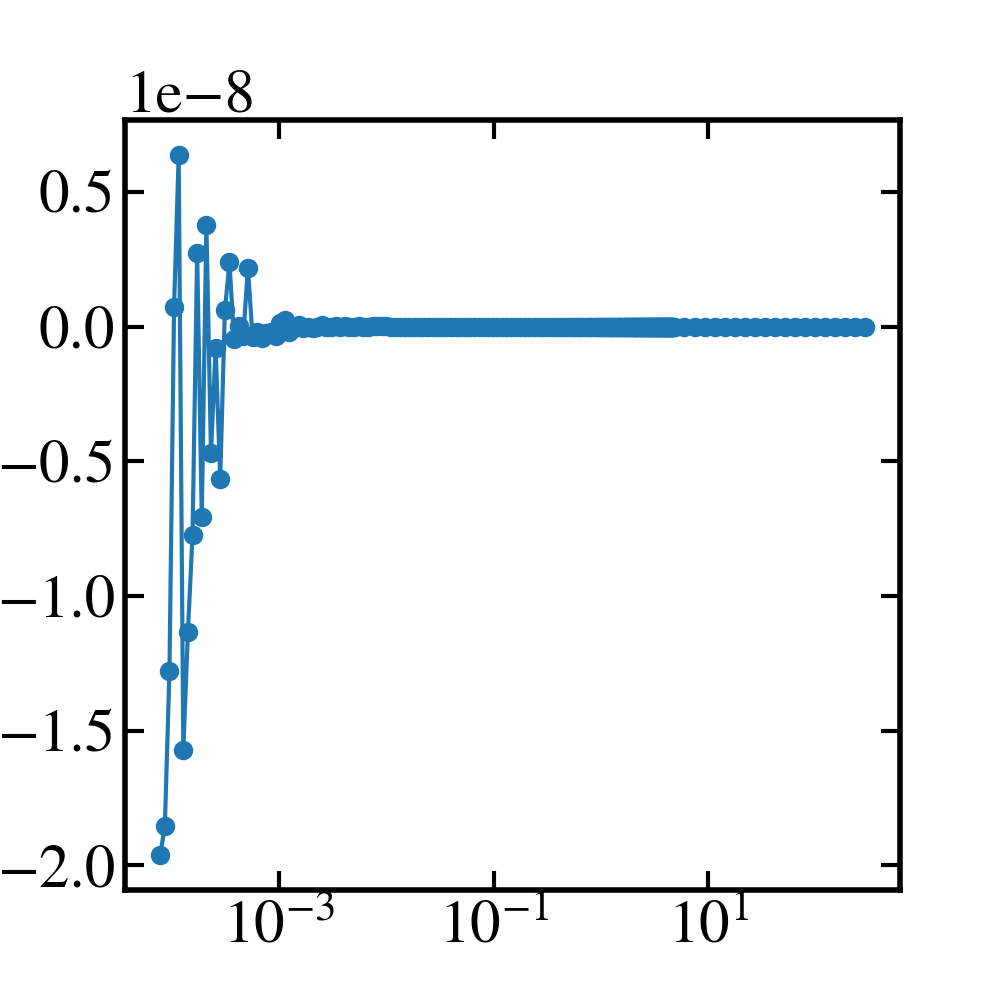

In [7]:
w1 = window(kh, 8, 0)
w2 = window(kh, 8, 1)

# just for checking
plt.figure(figsize=(5,5))
plt.semilogx(kh*8, w1-w2, 'o-')
# plt.semilogx(kh*8, w2, 'o-')

In [8]:
k = kh*h
w = window(kh, 8, 1)

sig8 = 0
dsig8o = 0

powers = As * (k/k0)**(ns-1)
dsig8 = Tt
dsig8 = dsig8**2
dsig8 = (w*k**2)**2*powers*dsig8

dlnk = 0.5
sig8o = sig8 + (dsig8[0]+dsig8o)*dlnk/2
sig8  = sig8o + np.trapz(dsig8, np.log(k))

In [9]:
sig8o, sig8

(2.6245262455029717e-20, 3.0072632100957472e-05)

# Let's compute `pnorm` for myself

In [11]:
# start with CAMB transfer function
Tcamb = np.loadtxt("/md/gilee/Multiverse/ic_gen/music_ic/MUSIC_old/test_Lbox/box_lmin07/camb_transfer_z200_w0-1.0_wa+0.0.txt", unpack=True)
kh = Tcamb[0,:] # kh [1/Mpc]
Tt = Tcamb[6,:] # total

# wave number
k = kh*h

# window functions
w_camb  = window(kh, 8, 1)
w_music = window(kh, 8, 0)

# for calculating sigma8
dsig8   = w_camb**2 * k**4 * As * (k/k0)**(ns-1)* Tt*Tt # CAMB
dSigma8 = kh*kh* w*w * kh**ns *Tt*Tt #MUSIC

In [12]:
sig8    = sig8o + np.trapz(dsig8, np.log(k))
sigma0  = 4*np.pi * np.trapz(dSigma8, kh)

In [14]:
np.sqrt(sig8), 0.00548385, np.sqrt(sig8) - 0.00548385 # this value from results.get_sigma8()

(0.005483851940101727, 0.00548385, 1.9401017268411147e-09)

In [16]:
mypnorm = sig8 / sigma0

In [17]:
mypnorm

4.1614005698399355e-11

$pnorm = \frac{A_s \times k_0^{1-n_{spec}} \times h^{3+n_{spec}}}{4 \pi (\delta_P + 1)}$

In [18]:
def compute_pnorm(ratio_Pcamb_Pmusic):
    pnorm = As * pow(k0, 1-ns) * pow(h, 3+ns)
    pnorm/= 4 * np.pi * (ratio_Pcamb_Pmusic)
    return pnorm

In [20]:
compute_pnorm(1)

4.16077467442774e-11

In [22]:
mypnorm / compute_pnorm(1) # ~ 0.015 % diff

1.000150427615329

If the formulas above are correct, `pnorm` should be calculated correctly in MUSIC!  

I suspected that the integration function used to calculate `pnorm` might be the issue..  
So I replaced `integrate` with `integrate_trapezoidal`.  
However, the value of `pnorm` still has 0.95 times smaller value.  
Then, changing the calculation method may not be a soultion.  

So, the question are:
- Is it really not an issue with `sig8o`?
- Could the problem be with the `dSigma8` function?
- Or is there an issue when taking the value of `m_Cosmology.sigma8`?

**To be more certain, debugging seems necessary...**

Question!  

```cpp
return m_Cosmology.sigma8*m_Cosmology.sigma8/sigma0;
```

Here, `m_Cosmology.sigma8` is the `sigma_8` value from the config file.   
**I provided it as the WMAP5 value at $z=0$, but based on the above calculation,  
shouldn't it be the vlaue at $z=200$?**  

Just in case, I tried changing the `sigma_8` value as one at $z=200$, but it sill seems not good...